In [13]:
import numpy as np
import pandas as pd
import sys
from scipy.stats import f_oneway
import os
from sklearn import preprocessing
%matplotlib inline
import matplotlib.pyplot as plt

from genetic import GeneticExtractor
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from pyts.transformation import ShapeletTransform
from pyts.datasets import load_gunpoint
from scipy.fftpack import fft, ifft
np.random.seed(1337)  # Random seed for reproducibility


# from tslearn.datasets import UCR_UEA_datasets

ModuleNotFoundError: No module named 'orange'

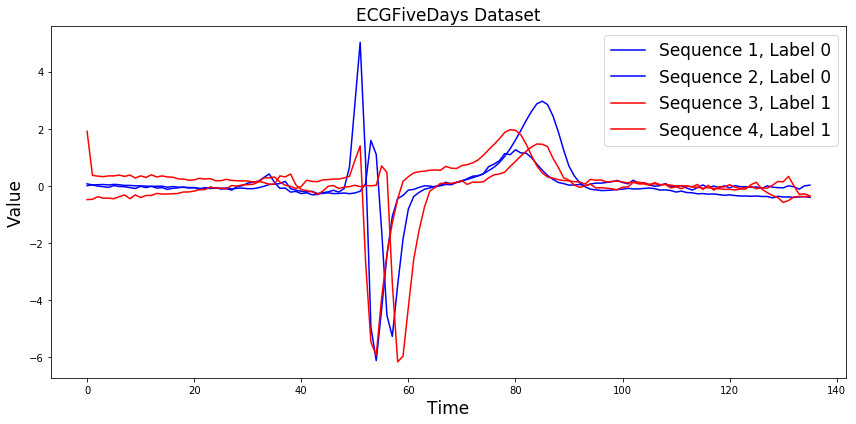

KeyboardInterrupt: 

In [29]:
# Load the GunPoint dataset
def TSC_data_loader(dataset_name):
    Train_dataset = np.loadtxt(
        os.getcwd()[:] + '/datasets/UCRArchive_2018/' + dataset_name + '/' + dataset_name + '_TRAIN.tsv')
    Test_dataset = np.loadtxt(
        os.getcwd()[:] + '/datasets/UCRArchive_2018/' + dataset_name + '/' + dataset_name + '_TEST.tsv')
    Train_dataset = Train_dataset.astype(np.float64)
    Test_dataset = Test_dataset.astype(np.float64)

    # 划分数据集，第一列标签为y，后续数据为x
    X_train = Train_dataset[:, 1:]
    y_train = Train_dataset[:, 0:1]

    X_test = Test_dataset[:, 1:]
    y_test = Test_dataset[:, 0:1]

    # 将标签改为0和1
    le = preprocessing.LabelEncoder()
    le.fit(np.squeeze(y_train, axis=1))
    y_train = le.transform(np.squeeze(y_train, axis=1))  # 删除维度，方便后续画图
    y_test = le.transform(np.squeeze(y_test, axis=1))

    return X_train, y_train, X_test, y_test
X, y, X_test, y_test = TSC_data_loader('ECGFiveDays')

plt.figure(figsize=(12, 6))

selected_0 = 0
selected_1 = 0

# 绘制前10条序列，按标签区别颜色
for i in range(len(y)):
    # 获取当前序列的标签
    label = y[i]

    # 如果当前标签为0且已选择的标签为0的序列数量小于2
    if label == 0 and selected_0 < 2:
        color = 'blue'
        selected_0 += 1
    # 如果当前标签为1且已选择的标签为1的序列数量小于2
    elif label == 1 and selected_1 < 2:
        color = 'red'
        selected_1 += 1
    # 否则继续下一轮循环
    else:
        continue

    # 绘制当前序列
    plt.plot(X[i], color=color, label=f"Sequence {i+1}, Label {label}")

# 添加图例
plt.legend(fontsize=17, markerscale=2.5)

# 设置标题和坐标轴标签
plt.title("ECGFiveDays Dataset", fontsize=17)
plt.xlabel("Time", fontsize=17)
plt.ylabel("Value", fontsize=17)

# 显示图形
plt.tight_layout()
path = os.getcwd()[:] + 'ECG5000.png'
plt.savefig(path, dpi=600)
plt.show()


# def calculate_fft(row):
#     spectrum = np.fft.fft(row)
#     freqs = np.fft.fftfreq(len(row))
#     return freqs, spectrum

# # 遍历每一行数据，计算傅里叶频谱并绘制图像
#
# row = X[5, :]
# freqs, spectrum = calculate_fft(row)
# fft_res = abs(spectrum)[:len(spectrum)//2] / len(row) * 2
#
# plt.figure(figsize=(8,4))
# # 原始信号
# plt.subplot(2,1,1)
# # plt.subplots_adjust(wspace=0,hspace=0.5) # 用来调整间距的
# plt.plot(row,linewidth=0.5)
# plt.title("时域信号")
#
# # 频谱图
# plt.subplot(2,1,2)
# plt.plot(fft_res,linewidth=0.5)
# plt.title("FFT")
# plt.show()

def calculate_dtw(seq1, seq2):
    distance, _ = fastdtw(seq1, seq2, dist=euclidean)
    return distance

def calculate_fft(window):
    return np.fft.fft(window)
    # return np.abs(fft(window))


def sliding_dtw_for_row(row, window_size):
    num_cols = len(row)
    max_dtw = float('inf')
    max_dtw_window = None
    max_dtw_start = None  # To store the starting index of max DTW window

    for i in range(num_cols - window_size + 1):
        window = row[i:i + window_size]
        dtw = calculate_dtw(window, row)

        if dtw < max_dtw:
            max_dtw = dtw
            max_dtw_window = window
            max_dtw_start = i

    return max_dtw_window, max_dtw_start

window_size = 16
fft_result_train = []
dtw_result_train = []
significant_freqs_train = []
for j in range(X.shape[0]):
    row = X[j, :]
    max_f_statistic = 0
    max_dtw_window, max_dtw_start = sliding_dtw_for_row(row, window_size)
    dtw_result_train.append(max_dtw_window)
    most_significant_spectrum = None
    significant_freq = None
    for i in range(0, len(row) - window_size + 1):
        window = row[i:i+window_size]
        spectrum = np.fft.fft(window)
        _, p_value = f_oneway(spectrum, np.zeros_like(spectrum))

        if p_value < 0.05 and p_value > max_f_statistic:
            max_f_statistic = p_value
            most_significant_spectrum = spectrum
            significant_freq = most_significant_spectrum
    significant_freqs_train.append(significant_freq)
fft_result_train = np.array(significant_freqs_train)
review_train = np.fft.ifft(fft_result_train).real
plt.figure(figsize=(8, 4))
plt.plot(np.fft.fftfreq(len(fft_result_train[0])), np.abs(fft_result_train[0]))
plt.title('Fourier Spectrum of ECG200 Row {}'.format(1))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [4]:
# Load ItalyPowerDemand dataset
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('ItalyPowerDemand')
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

PermissionError: [WinError 5] 拒绝访问。: 'C:\\Users\\14684\\.tslearn\\datasets\\UCR_UEA\\ItalyPowerDemand'

In [ ]:
# Visualize the timeseries in the train and test set
colors = ['r', 'b', 'g', 'y', 'c']

plt.figure(figsize=(10, 5))
for ts, label in zip(X_train, y_train):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the train set')
plt.show()

plt.figure(figsize=(10, 5))
for ts, label in zip(X_test, y_test):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the test set')
plt.show()

In [ ]:
# Extract the shapelets using the train set. Enabled verbosity. 
# Plotting is possible too, by setting plot='notebook' in jupyter or True else
genetic_extractor = GeneticExtractor(verbose=True, population_size=50, iterations=10, plot=None, location=True)
genetic_extractor.fit(X_train, y_train)

plt.figure()
for shap in genetic_extractor.shapelets:
    plt.plot(shap)
plt.title('The extracted shapelets')
plt.show()

x, y, y_err, y_max = [], [], [], []
for it, stat in genetic_extractor.history:
    x.append(it)
    y.append(stat['avg'])
    y_err.append(stat['std'] ** 1.25)
    y_max.append(stat['max'])
x, y, y_err, y_max = np.array(x), np.array(y), np.array(y_err), np.array(y_max)

plt.plot(x, y, 'k-', label='Average')
plt.fill_between(x, y-y_err, y+y_err, label='Variance')
plt.plot(x, y_max, 'k--', label='Maximum')
plt.title('The fitness (negative logloss) in function of the number of generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.show()

In [5]:
# Calculate distances from timeseries to extracted shapelets and fit a Logistic Regression model
distances_train = genetic_extractor.transform(X_train)
distances_test = genetic_extractor.transform(X_test)

lr = LogisticRegression(random_state=2020)
lr.fit(distances_train, y_train)

# Print the accuracy score on the test set
print('Accuracy LR = {}'.format(accuracy_score(y_test, lr.predict(distances_test))))

Accuracy LR = 0.9329446064139941
